# Data Processing & Modelling (Splitting out demographics)

This notebook has been created to merge, clean & process the data into a format useful for modelling and anaylsis. It follows on from the initial analysis done to gain a better understanding of the data. It has also been used to split the input data into the demographics that will be used to decided how the marketing campagins should be judged.

### Imports

In [1]:
# import general functions
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt

# import functions for modelling
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

### Functions

In [2]:
def clean_transcript_data(data):
    """
    this process cleans the values column and formats the transcript data
    """
    # creates a column for the type of interaction   
    data['interaction_type'] = [list(x.keys())[0] for x in data['value']]
    
    # creates a column related to the value amount or id    
    data['interaction_value'] = [list(x.values())[0] for x in data['value']]
    
    # drops the value column
    data = data.drop(columns=['value'])
    
    # cleans the interaction type column so offer id is consistent
    data['interaction_type'] = [x.replace('offer id','offer_id') for x in data['interaction_type']]
    
    # split out interaction_type
    temp_df = pd.get_dummies(data['interaction_type'])

    # combine the dataframes
    data = pd.concat([temp_df, data], axis=1, sort=True)
    
    # split out event
    temp_df = pd.get_dummies(data['event'])

    # combine the dataframes
    data = pd.concat([temp_df, data], axis=1, sort=True)

    # drop the original columns
    data = data.drop(columns=['interaction_type','event'])
    
    return data # returns the clean transcript data


def clean_profile_data(data):
    """
    this process clean age, income and became_member_on columns in the profile data
    """
    # rename the column 'id' to person
    data.columns = ['age','member joined','gender','person' ,'income']
    
    # replace 118 in the age column with a zero indicating no age 
    # it might be worth looking at this a seperate group of users later on
    data['age'] = data['age'].replace(118,0)

    # update the became_member_on column to a datetime format
    data['member joined'] = pd.to_datetime(data['member joined'], format='%Y%m%d')
    
    # replace the NaN's in the income
    data['income'] = data['income'].fillna(0)
    
    # replace M, F, O and None types to get the 4 groups of customers
    data['gender'] = data['gender'].replace('M','male')
    data['gender'] = data['gender'].replace('F','female')
    data['gender'] = data['gender'].replace('O','other')
    data['gender'] = data['gender'].fillna('unknown gender')

    # split the column into seperate columns
    temp_df = pd.get_dummies(data['gender'])

    # combine the dataframes
    data = pd.concat([temp_df, data], axis=1, sort=True)

    # drop the original column
    data = data.drop(columns=['gender'])

    return data

def clean_portfolio_data(data):
    """
    this process has been created to clean columns in the profile data
    """
    # splits the channels column into seperate columns
    # creates temporary dataframes and lists  
    temp_df = pd.DataFrame(columns=['web', 'email', 'mobile','social'])
    temp_list = []

    # loop through the rows and attach the values to a dic   
    for index, row in data.iterrows():
        for value in row['channels']:
             temp_list.append({'index': index, 'value':value})

    # change the list into dataframe
    temp_df = temp_df.append(temp_list, ignore_index=False, sort=True)
    temp_df = temp_df.groupby('index')['value'].value_counts()
    temp_df = temp_df.unstack(level=-1).fillna(0)
    
    # combine the dataframes
    data = pd.concat([temp_df, data], axis=1, sort=True)
    
    # split the column into seperate columns
    temp_df = pd.get_dummies(data['offer_type'])

    # combine the dataframes
    data = pd.concat([temp_df, data], axis=1, sort=True)

    # drop the original columns
    data = data.drop(columns=['offer_type','channels'])
    
    return data

def k_means_predictions(data, n_clusters=10):
    """
    this can be used to see how to split the demographics data up for the analysis
    """
    # Apply feature scaling to the demographics data.
    scaler = StandardScaler()
    scaler.fit(data)
    input_data = scaler.transform(data)
    
    # run k-means over different cluster counts to see the best number of groups to split our demographic data into
    ad = {}
    cluster_counts = [2,3,4,5,6,7,8,9,10,12,14,16,18,20,22]
    for x in cluster_counts:
        kmeans = KMeans(n_clusters=x, max_iter=1000).fit(input_demo_data)
        ad[x] = kmeans.inertia_
    plt.plot(list(ad.keys()), list(ad.values()))
    plt.xlabel("Number of cluster")
    plt.ylabel("Average Distance")
    plt.show()
    
    # create and run the model
    final_kmeans = KMeans(n_clusters=n_clusters, max_iter=1000).fit(input_demo_data)
    predict = final_kmeans.predict(input_demo_data)
       
    # add the pedictions for the clustering onto the original dataset
    data['cluster'] = predict
    
    return data

### Global Variables

In [3]:
# read in the different datasources
portfolio_df = pd.read_json('data/portfolio.json', lines=True)
portfolio_df.head()

,channels,difficulty,duration,id,offer_type,reward
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5


In [4]:
profile_df = pd.read_json('data/profile.json', lines=True)
profile_df.head()

,age,became_member_on,gender,id,income
0,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0
2,118,20180712,None,38fe809add3b4fcf9315a9694bb96ff5,NaN
3,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
4,118,20170804,None,a03223e636434f42ac4c3df47e8bac43,NaN


In [5]:
transcript_df = pd.read_json('data/transcript.json', lines=True)
transcript_df.head()

,event,person,time,value
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'}
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}


### Processing

In [6]:
# run the initial cleaning on each dataset
clean_port_df = clean_portfolio_data(portfolio_df)
clean_port_df.head()

,bogo,discount,informational,email,mobile,social,web,difficulty,duration,id,reward
0.0,1,0,0,1.0,1.0,1.0,0.0,10,7,ae264e3637204a6fb9bb56bc8210ddfd,10
1.0,1,0,0,1.0,1.0,1.0,1.0,10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,10
2.0,0,0,1,1.0,1.0,0.0,1.0,0,4,3f207df678b143eea3cee63160fa8bed,0
3.0,1,0,0,1.0,1.0,0.0,1.0,5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,5
4.0,0,1,0,1.0,0.0,0.0,1.0,20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,5


In [7]:
clean_prof_df = clean_profile_data(profile_df)
clean_prof_df.head()

,female,male,other,unknown gender,age,member joined,person,income
0,0,0,0,1,0,2017-02-12,68be06ca386d4c31939f3a4f0e3dd783,0.0
1,1,0,0,0,55,2017-07-15,0610b486422d4921ae7d2bf64640c50b,112000.0
2,0,0,0,1,0,2018-07-12,38fe809add3b4fcf9315a9694bb96ff5,0.0
3,1,0,0,0,75,2017-05-09,78afa995795e4d85b5d9ceeca43f5fef,100000.0
4,0,0,0,1,0,2017-08-04,a03223e636434f42ac4c3df47e8bac43,0.0


In [8]:
clean_trans_df = clean_transcript_data(transcript_df)
clean_trans_df.head()

,offer completed,offer received,offer viewed,transaction,amount,offer_id,person,time,interaction_value
0,0,1,0,0,0,1,78afa995795e4d85b5d9ceeca43f5fef,0,9b98b8c7a33c4b65b9aebfe6a799e6d9
1,0,1,0,0,0,1,a03223e636434f42ac4c3df47e8bac43,0,0b1e1539f2cc45b7b9fa7c272da2e1d7
2,0,1,0,0,0,1,e2127556f4f64592b11af22de27a7932,0,2906b810c7d4411798c6938adc9daaa5
3,0,1,0,0,0,1,8ec6ce2a7e7949b1bf142def7d0e0586,0,fafdcd668e3743c1bb461111dcafc2a4
4,0,1,0,0,0,1,68617ca6246f4fbc85e91a2a49552598,0,4d5c57ea9a6940dd891ad53e9dbe8da0


Now that some intital cleaning has been performed we can look further into what we want to do with the data. There are a number of ways we can merge/spilt the whole dataset: based on demographic, transaction type or at campagin level.

### Offer influnce

The first thing we probably need to decide is how we will determine when an offer has influnced a purchase. For the sake of ease I will assume that if a user hasn't viewed an offer it didn't influence a purchase even if the offer was completed. I will also assume any users purchases before viewing an offer weren't influnenced and any after weren't unless the offer was completed. Obviously in the second case some users may have purchased more but didn't reach the threshold for some offers but this is beyond judgement given the data. Given the above offers received isn't really needed.

In [9]:
# first I will find influnced purchases by the campagins
# split out the transactions data
transactions_df = clean_trans_df[clean_trans_df['transaction'] == 1]

# split out offers viewed
offers_viewed = clean_trans_df[(clean_trans_df['offer viewed'] == 1)]
offers_viewed = offers_viewed[['person','time','interaction_value']]
offers_viewed.columns = ['person','time_viewed','value_viewed']

# split out offers & offer completed
offers_completed = clean_trans_df[(clean_trans_df['offer completed'] == 1)]
offers_completed = offers_completed[['person','time','interaction_value']]
offers_completed.columns = ['person','time_completed','value_completed']

# merge all three datasets on the transactions, views and offers completed
merged_viewed = transactions_df.merge(offers_viewed, on=['person'])
merged_completed = merged_viewed.merge(offers_completed, how='left', 
                                       left_on=['person','value_viewed'], 
                                       right_on =['person','value_completed'])

# drop any blank data indicating transaction wasn't related
merged_completed = merged_completed.dropna() 

# keep data where time viewed is prior purchase time/time completed but purchase is before offer completed
# these are the transactions that are likely to be influenced by the offer
influenced_trans = merged_completed[(merged_completed['time_viewed'] <= merged_completed['time']) & 
                                    (merged_completed['time_viewed'] <= merged_completed['time_completed']) &
                                    (merged_completed['time_completed'] >= merged_completed['time'])]

In [10]:
influenced_trans.head()

,offer completed,offer received,offer viewed,transaction,amount,offer_id,person,time,interaction_value,time_viewed,value_viewed,time_completed,value_completed
10,0,0,0,1,1,0,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,0,34.56,0,2906b810c7d4411798c6938adc9daaa5,0.0,2906b810c7d4411798c6938adc9daaa5
35,0,0,0,1,1,0,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,354,18.42,342,2298d6c36e964ae4a3e7e9706d1fb8c2,354.0,2298d6c36e964ae4a3e7e9706d1fb8c2
52,0,0,0,1,1,0,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,474,21.13,462,0b1e1539f2cc45b7b9fa7c272da2e1d7,474.0,0b1e1539f2cc45b7b9fa7c272da2e1d7
57,0,0,0,1,1,0,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,540,24.3,516,4d5c57ea9a6940dd891ad53e9dbe8da0,540.0,4d5c57ea9a6940dd891ad53e9dbe8da0
62,0,0,0,1,1,0,54890f68699049c2a04d415abc25e717,330,15.61,186,2298d6c36e964ae4a3e7e9706d1fb8c2,330.0,2298d6c36e964ae4a3e7e9706d1fb8c2


In [11]:
# Next I will make another dataset without the purchases. This is important for selecting demographics for the analysis
uninflunced_trans = transactions_df.merge(influenced_trans, how='left', on=['offer completed','offer received',
                                                                            'person','interaction_value',
                                                                            'offer viewed','transaction',
                                                                            'amount','offer_id','time']).fillna(-1)

In [12]:
uninflunced_trans = uninflunced_trans[uninflunced_trans['time_viewed'] < 0]

In [13]:
uninflunced_trans = uninflunced_trans.drop(columns=['time_viewed','value_viewed','time_completed','value_completed'])

In [15]:
uninflunced_trans.head()

,offer completed,offer received,offer viewed,transaction,amount,offer_id,person,time,interaction_value
0,0,0,0,1,1,0,02c083884c7d45b39cc68e1314fec56c,0,0.83
2,0,0,0,1,1,0,54890f68699049c2a04d415abc25e717,0,13.23
3,0,0,0,1,1,0,b2f1cd155b864803ad8334cdf13c4bd2,0,19.51
4,0,0,0,1,1,0,fe97aa22dd3e48c8b143116a8403dd52,0,18.97
6,0,0,0,1,1,0,bbeb54e861614fc7b22a8844f72dca6c,0,0.22


### Finding demographics

Splitting into the different demographics could be done simply by age range, gender and income by selecting certain ranges e.g. females aged between 20-30 with a high income. However, a much better way of doing it would be to see if their is any patterns based on spending habits. Using the transaction data and the profile data an unsupervised learning method can be deployed to find certian demographics using starbucks.

In [16]:
# Total value of transactions made by a user
prof_trans = pd.DataFrame(uninflunced_trans.groupby('person')['interaction_value'].sum().values, 
                          index=uninflunced_trans.groupby('person')['interaction_value'].sum().index,
                          columns=['total sales'])

# Number of transactions made by a user
prof_trans['number of sales'] = uninflunced_trans.groupby('person')['interaction_value'].count().values

# Average value of transactions made by a user
prof_trans['mean spend'] = (prof_trans['total sales']/prof_trans['number of sales'])

# set person as index
clean_prof_df.set_index('person', inplace = True)

# combine the two datasets
user_data = pd.concat([clean_prof_df, prof_trans], axis=1, sort=True).fillna(0)

Now we have all the data on our users transactions and the demographics to try to see how we should split up our demographic data. At this point we have ingorned any of the offers influnences on the demographics and that should be fine for this analysis as if some users are more heavily influnced by an offer we want that to stand out in the demographic split e.g. if users between 20-30 spend much more due to offers we want them as a seperate cluster in our customer segmentaion technique.

Now we have our user data and transaction history it might be worth creating an extra column to show how much they've spent/number of transactions a week on average since signing up as this might be more insightful than just looking at total transaction data.

In [17]:
# I will take the last date in the data as the final time data was collected
final_date = user_data['member joined'].max()

# Then we will create a length in weeks that the user has been a member at starbucks
user_data['membership length'] = [round((final_date - x).days / 7,0) for x in user_data['member joined']]

# This can be used to calculate the average money spent per week
user_data['weekly spend'] = user_data['total sales']/user_data['membership length']

# Drop memeber joined column
user_data = user_data.drop(columns=['member joined'])

In [18]:
user_data.head()

,female,male,other,unknown gender,age,income,total sales,number of sales,mean spend,membership length,weekly spend
0009655768c64bdeb2e877511632db8f,0,1,0,0,33,72000.0,127.60,8.0,15.950000,66.0,1.933333
00116118485d4dfda04fdbaba9a87b5c,0,0,0,1,0,0.0,4.09,3.0,1.363333,13.0,0.314615
0011e0d4e6b944f998e987f904e8c1e5,0,0,1,0,40,57000.0,45.48,3.0,15.160000,28.0,1.624286
0020c2b971eb4e9188eac86d93036a77,1,0,0,0,59,90000.0,81.29,3.0,27.096667,125.0,0.650320
0020ccbbb6d84e358d3414a3ff76cffd,1,0,0,0,24,60000.0,117.55,9.0,13.061111,89.0,1.320787


Now we have the user gender, age, income, lifetime sales, number of sales, averge sale, membership length, sales per week and average number of transactions per week. For the sake of removing other features of the analysis it's worth removing number of sales and total sales so that membership length is only accounted for once.

In [19]:
# find rows with infinite values
inf_rows = user_data.index[np.isinf(user_data).any(1)]
inf_rows_df = user_data.loc[inf_rows]

# replace the values in Avg Value & Avg Trans that have infinites due to short membership
inf_rows_df['weekly spend'] = inf_rows_df['total sales']

# drop the infinite rows from the orginal df and append the new ones
user_data = user_data.drop(inf_rows)
user_data = user_data.append(inf_rows_df)

# fill NaN's in the Avg Value & Avg Trans column
user_data = user_data.fillna(0)

# remove unwanted columns
demographics_input = user_data.drop(columns=['total sales','number of sales'])

We also want to keep the zero income and unknown age users as they may indicate another group of users that are represented in the data. Next we will apply feature scaling as the income columns large range may have a negative affect on the unsupervised learning algorthim.

In [20]:
# Apply feature scaling to the demographics data.
scaler = StandardScaler()
scaler.fit(demographics_input)
input_demo_data = scaler.transform(demographics_input)

Now our input data is ready to perform unsupervised learning on to try to determine which demographics we show be splitting the data into. Here we will use the kmeans algorthim which is a clustering algorthim and we will split the data into the number of clusters that

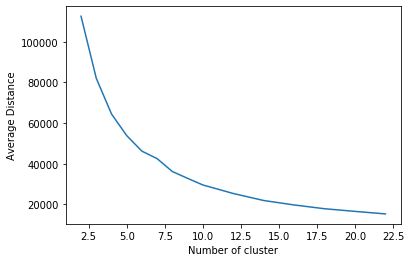

In [21]:
# run k-means over different cluster counts to see the best number of groups to split our demographic data into
ad = {}
cluster_counts = [2,3,4,5,6,7,8,9,10,12,14,16,18,20,22]
for x in cluster_counts:
    kmeans = KMeans(n_clusters=x, max_iter=1000).fit(input_demo_data)
    ad[x] = kmeans.inertia_
plt.plot(list(ad.keys()), list(ad.values()))
plt.xlabel("Number of cluster")
plt.ylabel("Average Distance")
plt.show()

The results above show that splitting the users into 5-10 clusters gives the largest amount of information gain for the smallest number of splits in the data. Below I have split the data into 8 seperate clusters and we can seen what each one of these demographics looks like.

In [30]:
# create and run the model
final_kmeans = KMeans(n_clusters=8, max_iter=1000).fit(input_demo_data)
predict = final_kmeans.predict(input_demo_data)

# add the pedictions for the clustering onto the original dataset
demographics_output = demographics_input
demographics_output['cluster'] = predict

In [31]:
demographics_output.groupby('cluster')['female'].count()

cluster
0    5666
1    2337
2    2175
3    3719
4    2742
5     212
6      71
7      78
Name: female, dtype: int64

In [32]:
demographics_output.groupby('cluster').mean()

,female,male,other,unknown gender,age,income,mean spend,membership length,weekly spend
cluster,,,,,,,,,
0,0.000000,1.000000,0.0,0.0,51.249912,59757.853865,9.662100,37.512354,2.020722
1,1.000000,0.000000,0.0,0.0,59.011553,75632.006846,18.581287,129.336329,0.920667
2,0.000000,0.000000,0.0,1.0,0.000000,0.000000,2.158525,69.025287,0.394852
3,1.000000,0.000000,0.0,0.0,56.580264,68375.907502,13.983370,38.709062,2.564570
4,0.000000,1.000000,0.0,0.0,53.854486,63799.416484,12.616639,155.765864,0.584369
5,0.000000,0.000000,1.0,0.0,54.400943,63287.735849,12.739963,69.584906,1.806732
6,0.535211,0.464789,0.0,0.0,59.971831,86732.394366,210.199029,82.169014,16.094882
7,0.448718,0.551282,0.0,0.0,53.974359,70333.333333,32.566776,1.756410,86.407099


Looking at the clusters the data has been split into above shows there are many interesting features. Consumers with no age or gender information (Cluster 3) spent very little on average and are probably not that interested in using the membership at all. These might be able to be ruled out when judging marketing performance as they bring very little value. They make up around 2,000 users on the app.

Another obvious cluster (6) shows that users with short memberships (around a week) have very large order values this could be the influence of the reward scheme and maybe show users that could be easy to influence into buying more products. However, this is a very small amount of users and so it might not be useful.

One of the intital observations is that overall all of the clusters have a similar average age:

In [25]:
demographics_output.groupby('cluster')['age'].describe()

,count,mean,std,min,25%,50%,75%,max
cluster,,,,,,,,
0,5666.0,51.249912,17.369654,18.0,38.0,52.0,64.00,99.0
1,2175.0,0.000000,0.000000,0.0,0.0,0.0,0.00,0.0
2,6056.0,57.518494,16.902274,18.0,48.0,58.0,69.00,101.0
3,2742.0,53.854486,17.378493,18.0,42.0,55.0,66.00,100.0
4,78.0,53.974359,18.240083,19.0,42.0,53.5,65.75,92.0
5,71.0,59.971831,13.863592,22.0,52.0,61.0,67.00,97.0
6,212.0,54.400943,16.244710,20.0,43.0,55.0,66.00,100.0


This shows that age isn't a major contributing factor into how much users are paying or how often they go to Starbucks which means it shouldn't be a key focus of our demographic splits. This was surprising as I think the common perception is that Starbucks consumers would be a younger demographic.

One of the biggest impacts seemed to come from gender. Interestingly majority of female consumers have been grouped together in cluster 0:

In [26]:
demographics_output[demographics_output['cluster'] == 0].describe()

,female,male,other,unknown gender,age,income,mean spend,membership length,weekly spend,cluster
count,5666.0,5666.0,5666.0,5666.0,5666.000000,5666.000000,5666.000000,5666.000000,5666.000000,5666.0
mean,0.0,1.0,0.0,0.0,51.249912,59757.853865,9.662100,37.512354,2.020722,0.0
std,0.0,0.0,0.0,0.0,17.369654,19622.391948,10.234411,23.409956,3.901704,0.0
min,0.0,1.0,0.0,0.0,18.000000,30000.000000,0.000000,0.000000,0.000000,0.0
25%,0.0,1.0,0.0,0.0,38.000000,44000.000000,2.480000,20.000000,0.344830,0.0
50%,0.0,1.0,0.0,0.0,52.000000,57000.000000,4.420000,35.000000,0.858492,0.0
75%,0.0,1.0,0.0,0.0,64.000000,72000.000000,16.111500,50.000000,2.006186,0.0
max,0.0,1.0,0.0,0.0,99.000000,120000.000000,108.683333,103.000000,43.080000,0.0


This shows that female users mostly acted very similarly in terms of buying habits with similar weekly spend and mean spend per shop.

Cluster 5 has mainly very wealthy users who spend a considerable amount when they visit the store. The gender split is almost 50/50 but they are more likely to be older consumers:

In [27]:
demographics_output[demographics_output['cluster'] == 5].describe()

,female,male,other,unknown gender,age,income,mean spend,membership length,weekly spend,cluster
count,71.000000,71.000000,71.0,71.0,71.000000,71.000000,71.000000,71.000000,71.000000,71.0
mean,0.535211,0.464789,0.0,0.0,59.971831,86732.394366,210.199029,82.169014,16.094882,5.0
std,0.502309,0.502309,0.0,0.0,13.863592,17054.498985,109.171817,50.001425,21.764389,0.0
min,0.000000,0.000000,0.0,0.0,22.000000,44000.000000,113.563333,5.000000,2.682870,5.0
25%,0.000000,0.000000,0.0,0.0,52.000000,76000.000000,133.593333,38.000000,6.837157,5.0
50%,1.000000,0.000000,0.0,0.0,61.000000,87000.000000,165.713333,69.000000,10.991563,5.0
75%,1.000000,1.000000,0.0,0.0,67.000000,98000.000000,259.241250,123.500000,20.482478,5.0
max,1.000000,1.000000,0.0,0.0,97.000000,119000.000000,644.850000,200.000000,180.588000,5.0


Cluster 2 is everyone who identified them selves as other in terms of gender. That leaves 1 and 4 that are the catagories accositated with male consumers only:

In [28]:
demographics_output[demographics_output['cluster'] == 1].describe()

,female,male,other,unknown gender,age,income,mean spend,membership length,weekly spend,cluster
count,2175.0,2175.0,2175.0,2175.0,2175.0,2175.0,2175.000000,2175.000000,2175.000000,2175.0
mean,0.0,0.0,0.0,1.0,0.0,0.0,2.158525,69.025287,0.394852,1.0
std,0.0,0.0,0.0,0.0,0.0,0.0,1.586387,50.032793,1.005346,0.0
min,0.0,0.0,0.0,1.0,0.0,0.0,0.000000,0.000000,0.000000,1.0
25%,0.0,0.0,0.0,1.0,0.0,0.0,1.369444,30.000000,0.083723,1.0
50%,0.0,0.0,0.0,1.0,0.0,0.0,1.937143,51.000000,0.167381,1.0
75%,0.0,0.0,0.0,1.0,0.0,0.0,2.682500,107.000000,0.348833,1.0
max,0.0,0.0,0.0,1.0,0.0,0.0,21.014000,260.000000,15.950000,1.0


In [29]:
demographics_output[demographics_output['cluster'] == 4].describe()

,female,male,other,unknown gender,age,income,mean spend,membership length,weekly spend,cluster
count,78.000000,78.000000,78.0,78.0,78.000000,78.000000,78.000000,78.000000,78.000000,78.0
mean,0.448718,0.551282,0.0,0.0,53.974359,70333.333333,32.566776,1.756410,86.407099,4.0
std,0.500582,0.500582,0.0,0.0,18.240083,19781.052634,43.630573,2.297293,61.115751,0.0
min,0.000000,0.000000,0.0,0.0,19.000000,35000.000000,7.414286,0.000000,45.535000,4.0
25%,0.000000,0.000000,0.0,0.0,42.000000,54500.000000,14.753333,1.000000,51.765000,4.0
50%,0.000000,1.000000,0.0,0.0,53.500000,70000.000000,18.627500,1.000000,67.540000,4.0
75%,1.000000,1.000000,0.0,0.0,65.750000,85000.000000,24.547500,2.000000,101.302500,4.0
max,1.000000,1.000000,0.0,0.0,92.000000,109000.000000,258.752500,12.000000,527.030000,4.0


Users in cluster 4 appear to have a longer membershop and lower weekly spend. Whereas users in cluster 1 have a shorter membership time bit a higher weekly spend. Given the transaction history and user we can now assign uders to each of the 7 demographic catagories given above and ajust media targeting accordingly to the user in them. 